In [1]:
import numpy as np
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

from lafomo.datasets import ToyTranscriptomics, ReactionDiffusion, HomogeneousReactionDiffusion, P53Data
from lafomo.models import NeuralOperator
from lafomo.trainers import NeuralOperatorTrainer
from lafomo.plot import Plotter, plot_spatiotemporal_data, tight_kwargs
from lafomo.utilities.data import generate_neural_dataset_1d

C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid = torch.tensor(grid.reshape(1, s1, s2, 2), dtype=torch.float)
C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data.reshape(data.shape[0], s1, s2, 4), dtype=torch.float)


params torch.Size([1800, 4])


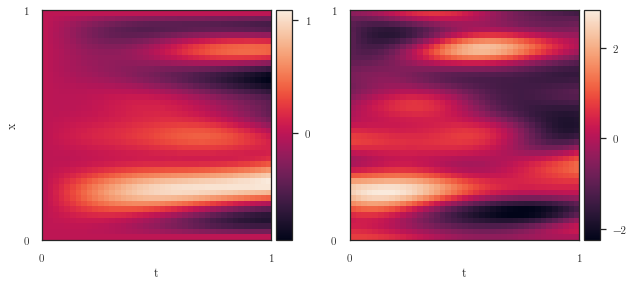

In [2]:
ntest = 50

dataset = ReactionDiffusion('../../data', nn_format=True, max_n=4000, ntest=ntest)

i = 3
tx = dataset.data[i][0]
lf = dataset.data[i][1]
ts = tx[:, :, 1].unique().sort()[0].numpy()
xs = tx[:, :, 2].unique().sort()[0].numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]

plot_spatiotemporal_data(
    [
        tx[:, :, 0].t(),
        lf[:, :, 0].t(),
    ],
    extent, nrows=1, ncols=2
)

batch_size = 50
train_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
if ntest > 0:
    test_loader = DataLoader(dataset.test_data, batch_size=ntest, shuffle=True)

params torch.Size([50, 4])
params torch.Size([50, 4])


C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


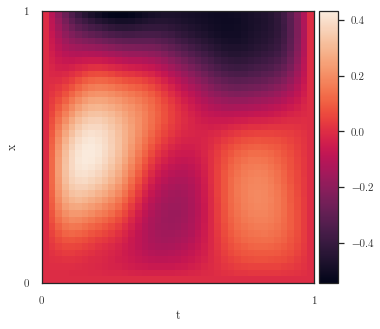

In [3]:
dataset = HomogeneousReactionDiffusion('../../data',
                                       one_fixed_sample=False,
                                       highres=True,
                                       nn_format=True,
                                       sub=1, ntest=0)
high_res_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)

dataset = HomogeneousReactionDiffusion('../../data',
                                       one_fixed_sample=False,
                                       highres=True,
                                       nn_format=True,
                                       sub=2, ntest=0)
subsampled_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
i = torch.randint(50, torch.Size([1]))[0]
tx = dataset.data[i][0]

plot_spatiotemporal_data(
    [torch.tensor(tx[:, :, 0])],
    extent, nrows=1, ncols=1
)

block_dim = 2
learning_rate = 1e-3

modes = 8
width = 32
in_channels = 3

In [4]:
ode_data = True
if ode_data:
    width = 20
    modes = 4
    in_channels = 6
    block_dim = 1
    learning_rate = 1e-3
    batch_size = 20
    dataset = ToyTranscriptomics(data_dir='../../data')
    ntrain = len(dataset.train_data)
    ntest = len(dataset.test_data)
    train_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset.test_data, batch_size=ntest, shuffle=True)
    num_outputs = 10

print(ntrain, ntest)

500 10


In [5]:
model = NeuralOperator(block_dim, in_channels, modes, width)
print(model.count_params())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
trainer = NeuralOperatorTrainer(model, [optimizer], train_loader, test_loader)

44781


In [10]:
trainer.train(80);

Epoch 081/160 - Loss: -0.92 (-0.00 -1.12 -0.37 0.20 0.37)
Epoch 082/160 - Loss: -0.91 (0.26 -1.11 -0.07 0.20 0.33)
Epoch 083/160 - Loss: -0.82 (-0.24 -1.01 -0.57 0.20 0.34)
Epoch 084/160 - Loss: -0.92 (0.00 -1.12 -0.37 0.20 0.37)
Epoch 085/160 - Loss: -0.97 (-0.07 -1.16 -0.41 0.19 0.35)
Epoch 086/160 - Loss: -0.97 (0.17 -1.16 -0.21 0.19 0.37)
Epoch 087/160 - Loss: -0.98 (-0.07 -1.17 -0.40 0.19 0.33)
Epoch 088/160 - Loss: -0.90 (0.09 -1.10 -0.25 0.19 0.34)
Epoch 089/160 - Loss: -0.99 (0.86 -1.19 0.46 0.19 0.40)
Epoch 090/160 - Loss: -0.91 (0.68 -1.11 0.33 0.20 0.35)
Epoch 091/160 - Loss: -1.02 (-0.18 -1.21 -0.52 0.19 0.34)
Epoch 092/160 - Loss: -0.98 (0.81 -1.17 0.45 0.19 0.36)
Epoch 093/160 - Loss: -0.87 (-0.35 -1.06 -0.69 0.19 0.34)
Epoch 094/160 - Loss: -0.86 (-0.24 -1.05 -0.57 0.19 0.33)
Epoch 095/160 - Loss: -0.81 (-0.05 -1.00 -0.38 0.19 0.33)
Epoch 096/160 - Loss: -1.02 (-0.22 -1.20 -0.60 0.19 0.38)
Epoch 097/160 - Loss: -1.02 (-0.01 -1.20 -0.36 0.18 0.35)
Epoch 098/160 - Loss: -1

In [35]:
from torch.nn.functional import softplus

def show_result(model, loader):
    x, y, params = next(iter(loader))
    out, params_out = model(x)

    if block_dim == 1:
        print()
        t = x[0, :, 0]
        fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
        for i in range(1, 5):
            axes[0].plot(t, x[0, :, i])#.shape, y.shape)
        axes[1].plot(t, y[0, :, 0], label='Target')
        print(out[0].shape)
        mean = out[0, :, 0].detach()
        std = softplus(out[0, :, 1].detach()).sqrt()
        print(std)
        axes[1].plot(t, mean, label='Prediction')
        axes[1].fill_between(t, mean + std, mean - std, label='Target')
        axes[1].legend()
        num_params = params_out.shape[1]
        params = params.view(params.shape[0], -1)[0]
        params_out = params_out[0].detach()
        plt.figure()
        plt.bar(np.arange(num_params)-0.2, params, width=0.4)
        plt.bar(np.arange(num_params)+0.2, params_out, width=0.4)
    else:
        num_t = x.shape[1]
        num_x = x.shape[2]
        print(num_t, num_x)
        # plot_spatiotemporal_data(
        #     [
        #         out[0, ..., 0].detach().view(num_t, num_x).t(),
        #         y[0, ..., 0].view(num_t, num_x).t(),
        #         x[0, ..., 0].view(num_t, num_x).t()
        #     ],
        #     extent, nrows=1, ncols=3,
        #     titles=['Latent (Prediction)', 'Latent (Target)', 'Test input']
        # )

        a = np.zeros((41, 41, 4))
        a[:, :, 0] = out[0, ..., 0].detach()
        a[:, :, 0] = (a[:, :, 0] - a[:, :, 0].min()) / (a[:, :, 0].max() - a[:, :, 0].min())
        a[:, :, 3] = out[0, ..., 1].detach()
        a[:, :, 3] = 1-(a[:, :, 3] - a[:, :, 3].min()) / (a[:, :, 3].max() - a[:, :, 3].min())
        # print(a)
        # a = out[0, ..., 0].detach()
        plt.imshow(a, origin='lower', extent=extent)
        # plt.imshow(out[0, ..., 1].detach(), origin='lower', extent=extent)
        plt.colorbar()
        out = out.squeeze()
        y_target = y.squeeze()
        print(params_out[0].detach(), params[0])
        print(F.mse_loss(out[...,0], y_target))
        # from lafomo.utilities.torch import smse, q2
        # print(y.shape, f_mean_test.shape)
        # print(smse(y_target, f_mean_test).shape)


torch.Size([11, 2])
tensor([0.0954, 0.0534, 0.0657, 0.0661, 0.0669, 0.0934, 0.1219, 0.1150, 0.1482,
        0.1835, 0.1663])

torch.Size([7, 2])
tensor([0.3061, 0.0313, 0.1063, 0.1008, 0.1379, 0.1114, 0.0939])


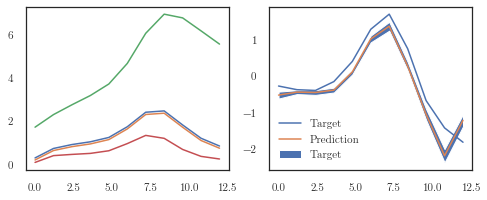

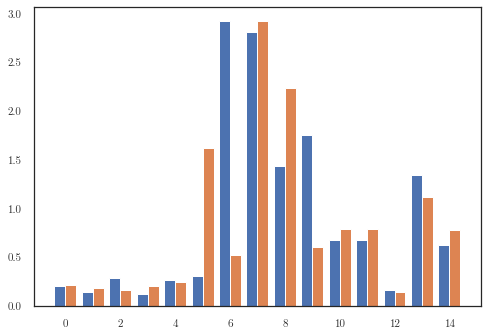

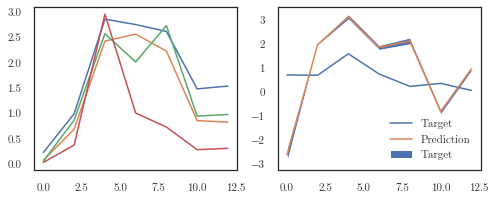

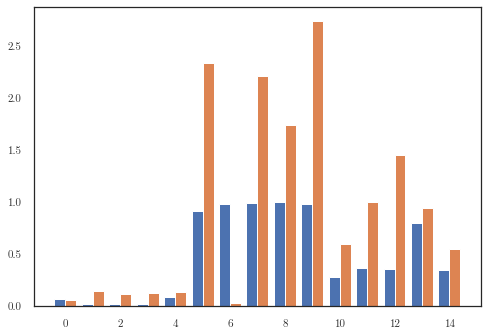

In [36]:
show_result(model, test_loader)
dataset = P53Data(data_dir='../../data', replicate=0)
train, test = generate_neural_dataset_1d(dataset.t_observed, [[dataset.m_observed, dataset.f_observed]], [dataset.params])
p53_loader = DataLoader(train, batch_size=1)
show_result(model, p53_loader)

In [9]:
s
show_result(model, subsampled_loader)
show_result(model, high_res_loader)

NameError: name 's' is not defined

In [ ]:
from lafomo.datasets import DrosophilaSpatialTranscriptomics

dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../data', scale=True, nn_format=True)

dataset.train_data[0] = (
    dataset.train_data[0][0],#.permute(1, 0, 2),
    dataset.train_data[0][1],
    dataset.train_data[0][2]
)
print(dataset.train_data[0][0].shape)
dros_loader = DataLoader(dataset.train_data)
plt.imshow(dataset.train_data[0][1][:, :, 0].t(), origin='lower', extent=extent)
plt.colorbar()

In [ ]:
show_result(model, dros_loader)

In [ ]:
torch.save(model.state_dict(), './saved_model3205.pt')

In [ ]:
# 0, 3, 6, 8, 48
i = 48
# i = torch.randint(50, torch.Size([1]))[0]
print(i)

x_sub, y_sub, params_sub = subsampled_loader.dataset[i]
x, y, params = high_res_loader.dataset[i]
out, _ = model(x.unsqueeze(0))
out_sub, _ = model(x_sub.unsqueeze(0))

num_t = x.shape[0]
num_x = x.shape[1]
num_t_sub = x_sub.shape[0]
num_x_sub = x_sub.shape[1]

plot_spatiotemporal_data(
    [
        x[..., 0].view(num_t, num_x).t(),
        out_sub[0, ..., 0].detach().view(num_t_sub, num_x_sub).t(),
        out[0, ..., 0].detach().view(num_t, num_x).t(),
        y_sub[..., 0].view(num_t_sub, num_x_sub).t(),
    ],
    extent, nrows=1, ncols=4, figsize=(12, 4),
    clim=[(x[...,0].min(), x[...,0].max())] + [(out[0].min(), out[0].max())] * 3,
    titles=['Test input', 'Prediction', 'Super-resolution Prediction', 'Low-res Target']
)
plt.tight_layout()
out = out.squeeze()
y_target = y.squeeze()
# plt.savefig('toy48.pdf', **tight_kwargs)

In [ ]:
dataset = HomogeneousReactionDiffusion('../../data', one_fixed_sample=True, nn_format=True, ntest=0)
print(dataset.train_data[0][0].shape)

toy_loader = DataLoader(dataset.train_data)
show_result(model, toy_loader)
print(dataset[0][1].shape)
print(dataset.orig_data.shape)
plt.figure()
d = dataset.train_data[0][0][:, :, 0]
x = HomogeneousReactionDiffusion('../../data', one_fixed_sample=True)
print(x[0][1].shape)
plt.imshow(x[0][1][0].view(41, 41).t(), origin='lower', extent=extent)
plt.figure()
plt.imshow(d.t(), origin='lower', extent=extent)

In [ ]:
dataset = HomogeneousReactionDiffusion('../../data', one_fixed_sample=True)
data = next(iter(dataset))
data_input, y = data
tx, y_target = data_input, y
print(tx.shape, y_target.shape)
# 1. Ensure that time axis must be in ascending order:
# We use mergesort to maintain relative order
t_sorted = np.argsort(tx[0, :], kind='mergesort')
print(t_sorted)
tx = tx[:, t_sorted]
y_target = y_target[:, self.t_sorted]

# 2. Discretise time
if hasattr(dataset, 'num_discretised'):
    num_discretised = dataset.num_discretised
else:
    num_discretised = 40
time = discretise(tx[0, :], num_discretised=num_discretised)
time = torch.tensor(time)
# 3. Discretise space
spatial_grid = self.discretise_spatial(tx)
spatial = torch.tensor(spatial_grid)

# 4. Reconstruct dataset
new_t = time.repeat(spatial.shape[0], 1).transpose(0, 1).reshape(-1)
t_mask = new_t == tx[0, :]

new_x = spatial.repeat(time.shape[0])
x_mask = new_x == tx[1, :]

mask = torch.stack([t_mask, x_mask])
self.tx = torch.stack([new_t, new_x])
self.y_target = y_target

In [ ]:
x, y, _ = toy_loader.dataset[0]
i = 0
# out, _ = model(x)
# out_sub, _ = model(x_sub)
num_t = x.shape[0]
num_x = x.shape[1]
print(x.shape, y.shape)
plot_spatiotemporal_data(
    [
        x[..., 0].view(41, 41).t(),
        # out[i, ..., 0].detach().view(num_t, num_x).t(),
        # y[i, ..., 0].view(41, 41).t(),
    ],
    extent, nrows=1, ncols=1, figsize=(12, 4),
    clim=[(x[...,2].min(), x[...,2].max())],#, (y[i,...,0].min(), y[i,...,0].max())],
    titles=['x', 'y']
)

In [ ]:
data = dataset.orig_data
print(data.shape)
plt.imshow(data[0, 2].view(41, 41))

In [ ]:
path = '../../data/ns_V1e-3_N5000_T50.mat'
from h5py import File

# u shape (50, 64, 64, 5000)
# a shape (64, 64, 5000)
# t shape (50, 1)

f = File(path)
print(f)
print(f['u'])

modes = 4
width = 20

batch_size = 10
batch_size2 = batch_size

epochs = 10
runtime = np.zeros(2, )

ntrain = 100
sub = 1
S = 64 // sub
T_in = 10
T = 40
S = 32

# train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
# train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]
train_a = torch.rand((100, 32, 32, 50))[:, :, :, :T_in]
train_a = train_a.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])
print(train_a.shape)
# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
# 32
gridx = gridx.reshape(1, S, 1, 1, 1).repeat([1, 1, S, T, 1])
# 1, 32, 32, 40, 1 (1, S, S, T, 1)
gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1, 1).repeat([1, S, 1, T, 1])
gridt = torch.tensor(np.linspace(0, 1, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1, 1, T, 1).repeat([1, S, S, 1, 1])
# (1, S, S, T, 1)
print(gridt.shape, gridx.shape)
# for t in range(10):
#     plt.figure()
#     plt.imshow(gridy.squeeze()[:, :, t])
print(gridx.repeat([ntrain,1,1,1,1]).shape)
train_a = torch.cat((gridx.repeat([ntrain,1,1,1,1]), gridy.repeat([ntrain,1,1,1,1]),
                       gridt.repeat([ntrain,1,1,1,1]), train_a), dim=-1)
print(train_a.shape)

In [ ]:
weight = torch.rand((width, width, modes, modes))
x_ft = torch.rand((10, width, 41, 21))
out_ft = torch.rand((10, width, 41, 21))
print('weight', weight.shape)
print('x_ft', x_ft.shape)
print('out_ft', out_ft.shape)

In [ ]:
from lafomo.utilities.torch import compl_mul2d
out_ft[:, :, :modes, :modes] = compl_mul2d(
    x_ft[:, :, :modes, :modes], weight
)
first = out_ft.clone()

print(x_ft[:, :, :modes, :modes].shape, weight.permute(1, 0, 2, 3).unsqueeze(0).shape)
out_ft[:, :, :modes, :modes] = torch.matmul(
    x_ft[:, :, :modes, :modes], weight.permute(1, 0, 2, 3)
)
second = out_ft.clone()
print(second.shape)